<a href="https://colab.research.google.com/github/gackouhamady/MLSD-25-26-Courses/blob/main/01-Data-Engineering/TPs_DataEngineering_M2_MLSD_Hamady_GACKOU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
  <img alt="University Paris Cité" src="https://img.shields.io/badge/University-Paris%20Cité-6f42c1?style=for-the-badge&logo=academia&logoColor=white">
  <img alt="Module Data Engineering" src="https://img.shields.io/badge/Course-Data%20Engineering-1976D2?style=for-the-badge&logo=databricks&logoColor=white">
  <img alt="Practical Lab" src="https://img.shields.io/badge/Type-Practical%20Lab-FF9800?style=for-the-badge&logo=jupyter&logoColor=white">
  <img alt="Day 1" src="https://img.shields.io/badge/Session-Day%201%20of%20Course-009688?style=for-the-badge&logo=googlecalendar&logoColor=white">
</p>

---

<p align="center">
  <strong>🎓 Master 2 Machine Learning for Data Science</strong>

</p>

---

<p align="center">

### 📊 Course Information  

| **Category**      | **Details**                          |
|-------------------|--------------------------------------|
| **University**    | University Paris Cité                |
| **Teaching Unit** | Data Engineering (Practical Labs)    |
| **Session**       | Day 1 of the course                  |
| **Instructor**    | Amine Ferddjaoui                     |
| **Student**       | Hamady GACKOU                        |

</p>





## Environment & Imports

In [ ]:
! pip  install  gensim

In [ ]:
# If needed (uncomment to install in a clean environment)
# %pip install numpy pandas scikit-learn nltk gensim sentence-transformers matplotlib

import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Text & ML
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA

# Word2Vec
from gensim.models import Word2Vec

# Sentence embeddings
from sentence_transformers import SentenceTransformer

# One-time NLTK downloads (stopwords, punkt)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Added this line to download the missing resource

# Set some defaults for nice plots
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 120

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# TP1 — Text Mining & Embeddings

This practical covers:
1) Building a tiny document collection (5–6 docs)
2) Text preprocessing (lowercase, cleaning, stopwords)
3) Bag of Words (BoW)
4) TF-IDF
5) Vocabulary inspection
6) Word2Vec (word embeddings) + 3D plot
7) MiniLM (sentence embeddings) + 3D plot


### 1) Create a tiny document collection (5–6 docs)

In [ ]:
# We create short, varied texts so models have something to learn from.
docs = [
    "Data engineering pipelines move raw data from sources to clean, reliable datasets.",
    "Machine learning models require careful feature engineering and evaluation.",
    "Streaming architectures use Kafka topics and Spark for real-time processing.",
    "NLP uses tokenization, embeddings, and transformers for text understanding.",
    "TF-IDF and Bag of Words are strong baselines for document classification.",
    "Word2Vec and MiniLM capture semantic meaning beyond simple term counts."
]

print(f"Number of documents: {len(docs)}")
for i, d in enumerate(docs, 1):
    print(f"[{i}] {d}")


Number of documents: 6
[1] Data engineering pipelines move raw data from sources to clean, reliable datasets.
[2] Machine learning models require careful feature engineering and evaluation.
[3] Streaming architectures use Kafka topics and Spark for real-time processing.
[4] NLP uses tokenization, embeddings, and transformers for text understanding.
[5] TF-IDF and Bag of Words are strong baselines for document classification.
[6] Word2Vec and MiniLM capture semantic meaning beyond simple term counts.


### 2) Preprocessing (lowercase, cleaning, stopwords)

In [ ]:
# Basic preprocessing function:
# - lowercase
# - remove punctuation/digits
# - tokenize
# - remove stopwords (English)
en_stop = set(stopwords.words('english'))
punct_table = str.maketrans("", "", string.punctuation)
digit_table = str.maketrans("", "", string.digits)

def preprocess(text):
    # lowercase
    text = text.lower()
    # remove punctuation and digits
    text = text.translate(punct_table).translate(digit_table)
    # remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    # tokenize
    tokens = nltk.word_tokenize(text)
    # remove stopwords and 1-char tokens
    tokens = [t for t in tokens if t not in en_stop and len(t) > 1]
    return tokens

tokenized_docs = [preprocess(d) for d in docs]

for i, toks in enumerate(tokenized_docs, 1):
    print(f"[{i}] tokens -> {toks}")


[1] tokens -> ['data', 'engineering', 'pipelines', 'move', 'raw', 'data', 'sources', 'clean', 'reliable', 'datasets']
[2] tokens -> ['machine', 'learning', 'models', 'require', 'careful', 'feature', 'engineering', 'evaluation']
[3] tokens -> ['streaming', 'architectures', 'use', 'kafka', 'topics', 'spark', 'realtime', 'processing']
[4] tokens -> ['nlp', 'uses', 'tokenization', 'embeddings', 'transformers', 'text', 'understanding']
[5] tokens -> ['tfidf', 'bag', 'words', 'strong', 'baselines', 'document', 'classification']
[6] tokens -> ['wordvec', 'minilm', 'capture', 'semantic', 'meaning', 'beyond', 'simple', 'term', 'counts']


### 3) Bag of Words (BoW)

In [ ]:
# For BoW and TF-IDF, we pass a preprocessor that does minimal cleaning because
# scikit-learn will do its own tokenization. We also pass stopwords="english".
def minimal_prep(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[^\w\s]", " ", s)       # remove punctuation to spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

bow_vectorizer = CountVectorizer(preprocessor=minimal_prep, stop_words="english")
X_bow = bow_vectorizer.fit_transform(docs)   # sparse matrix (n_docs × vocab_size)

print("BoW shape (docs × vocab):", X_bow.shape)
print("Sample BoW row (doc 1):")
print(pd.DataFrame(X_bow[0].toarray(), columns=bow_vectorizer.get_feature_names_out()).iloc[:, :12])


BoW shape (docs × vocab): (6, 47)
Sample BoW row (doc 1):
   architectures  bag  baselines  capture  careful  classification  clean  \
0              0    0          0        0        0               0      1   

   counts  data  datasets  document  embeddings  
0       0     2         1         0           0  


### 4) TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(preprocessor=minimal_prep, stop_words="english")
X_tfidf = tfidf_vectorizer.fit_transform(docs)

print("TF-IDF shape (docs × vocab):", X_tfidf.shape)
print("Sample TF-IDF row (doc 1):")
print(pd.DataFrame(X_tfidf[0].toarray(), columns=tfidf_vectorizer.get_feature_names_out()).iloc[:, :12])


TF-IDF shape (docs × vocab): (6, 47)
Sample TF-IDF row (doc 1):
   architectures  bag  baselines  capture  careful  classification     clean  \
0            0.0  0.0        0.0      0.0      0.0             0.0  0.306104   

   counts      data  datasets  document  embeddings  
0     0.0  0.612207  0.306104       0.0         0.0  


### 5) Inspect extracted vocabulary

In [ ]:
vocab_bow = bow_vectorizer.get_feature_names_out()
vocab_tfidf = tfidf_vectorizer.get_feature_names_out()

print("Vocabulary size (BoW):", len(vocab_bow))
print("Vocabulary size (TF-IDF):", len(vocab_tfidf))

# Show a small, sorted preview for readability
print("\nPreview (sorted) — BoW:")
print(sorted(list(vocab_bow))[:30])

print("\nPreview (sorted) — TF-IDF:")
print(sorted(list(vocab_tfidf))[:30])


Vocabulary size (BoW): 47
Vocabulary size (TF-IDF): 47

Preview (sorted) — BoW:
['architectures', 'bag', 'baselines', 'capture', 'careful', 'classification', 'clean', 'counts', 'data', 'datasets', 'document', 'embeddings', 'engineering', 'evaluation', 'feature', 'idf', 'kafka', 'learning', 'machine', 'meaning', 'minilm', 'models', 'nlp', 'pipelines', 'processing', 'raw', 'real', 'reliable', 'require', 'semantic']

Preview (sorted) — TF-IDF:
['architectures', 'bag', 'baselines', 'capture', 'careful', 'classification', 'clean', 'counts', 'data', 'datasets', 'document', 'embeddings', 'engineering', 'evaluation', 'feature', 'idf', 'kafka', 'learning', 'machine', 'meaning', 'minilm', 'models', 'nlp', 'pipelines', 'processing', 'raw', 'real', 'reliable', 'require', 'semantic']


### 6) Word2Vec (word embeddings) + 3D visualization

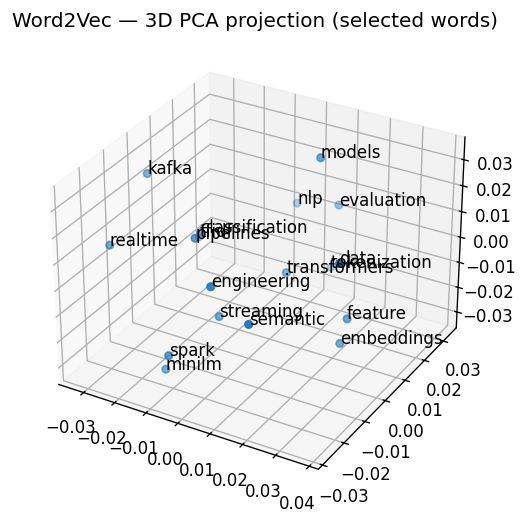

In [ ]:
# Train a small Word2Vec model on our tokenized documents.
# With a tiny corpus, embeddings won't be amazing, but enough for demo.
w2v_model = Word2Vec(
    sentences=tokenized_docs,
    vector_size=100,   # embedding dimension
    window=5,
    min_count=1,
    workers=2,
    epochs=200,        # more epochs to compensate tiny data
    sg=1               # skip-gram tends to work better on small corpora
)

# Pick a small set of interesting words to visualize
target_words = [
    "data", "engineering", "pipelines", "models", "feature", "evaluation",
    "streaming", "kafka", "spark", "realtime",
    "nlp", "tokenization", "embeddings", "transformers",
    "tfidf", "classification", "word2vec", "minilm", "semantic"
]
present_words = [w for w in target_words if w in w2v_model.wv.key_to_index]

# Build matrix (n_words × dim)
word_vecs = np.vstack([w2v_model.wv[w] for w in present_words])

# Reduce to 3D using PCA for plotting
pca = PCA(n_components=3, random_state=42)
word_vecs_3d = pca.fit_transform(word_vecs)

# 3D plot (matplotlib)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401; needed for 3d projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(word_vecs_3d[:,0], word_vecs_3d[:,1], word_vecs_3d[:,2])

# Add labels
for (x, y, z), w in zip(word_vecs_3d, present_words):
    ax.text(x, y, z, w)

ax.set_title("Word2Vec — 3D PCA projection (selected words)")
plt.show()


### 7) MiniLM (sentence embeddings) + 3D visualization

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence embeddings shape: (6, 384)


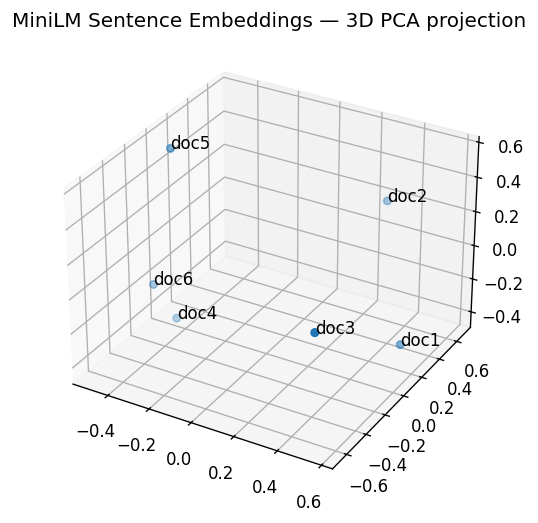


Pairwise cosine similarity between sentences:

       doc1   doc2   doc3   doc4   doc5   doc6
doc1  1.000  0.360  0.322  0.201  0.078  0.120
doc2  0.360  1.000  0.101  0.194  0.200  0.179
doc3  0.322  0.101  1.000  0.096  0.088  0.120
doc4  0.201  0.194  0.096  1.000  0.376  0.533
doc5  0.078  0.200  0.088  0.376  1.000  0.418
doc6  0.120  0.179  0.120  0.533  0.418  1.000


In [ ]:
# Load a small, fast sentence-transformer (MiniLM)
# 'all-MiniLM-L6-v2' returns 384-dim sentence embeddings
sbert = SentenceTransformer("all-MiniLM-L6-v2")

# Compute a 384-dim embedding for each full sentence/document
sent_emb = sbert.encode(docs, convert_to_numpy=True, normalize_embeddings=True)
print("Sentence embeddings shape:", sent_emb.shape)  # (n_docs, 384)

# Reduce to 3D for visualization
pca2 = PCA(n_components=3, random_state=42)
sent_3d = pca2.fit_transform(sent_emb)

# Plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sent_3d[:,0], sent_3d[:,1], sent_3d[:,2])

for (x, y, z), label in zip(sent_3d, [f"doc{i+1}" for i in range(len(docs))]):
    ax.text(x, y, z, label)

ax.set_title("MiniLM Sentence Embeddings — 3D PCA projection")
plt.show()

# Optional: inspect pairwise cosine similarities to see which docs are closest
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(sent_emb)
print("\nPairwise cosine similarity between sentences:\n")
print(pd.DataFrame(sim, index=[f"doc{i+1}" for i in range(len(docs))],
                        columns=[f"doc{i+1}" for i in range(len(docs))]).round(3))


###Conclusion of  TP1 :

In this practical, we explored several text representation methods, from the simplest (Bag of Words, TF-IDF) to more advanced embeddings (Word2Vec, MiniLM).  
Each approach has specific strengths and weaknesses:

---

## Bag of Words (BoW)
**Strengths:**
- Simple and easy to implement.  
- Works well for small datasets and as a baseline.  
- Interpretable: you know exactly which words are counted.  

**Weaknesses:**
- Ignores word order and context.  
- Produces very sparse, high-dimensional vectors.  
- Cannot capture semantic similarity (e.g., “car” vs. “automobile”).  

---

## TF-IDF
**Strengths:**
- Improves BoW by weighting down common words and highlighting rare, informative terms.  
- Good baseline for document classification and information retrieval.  
- Still interpretable (term weights can be inspected).  

**Weaknesses:**
- Still ignores word order and deep semantics.  
- High-dimensional and sparse representation.  
- Vocabulary is fixed, so unseen words at test time are ignored.  

---

## Word2Vec
**Strengths:**
- Produces dense, low-dimensional embeddings.  
- Captures semantic similarity (e.g., “king – man + woman ≈ queen”).  
- Learns relationships between words, not just frequencies.  

**Weaknesses:**
- Requires a large corpus to train good embeddings.  
- Context is limited (window size).  
- Cannot handle out-of-vocabulary words unless extended with subword models.  

---

## MiniLM (Sentence Embeddings)
**Strengths:**
- Encodes entire sentences into fixed-size embeddings.  
- Captures context and meaning beyond individual words.  
- Pretrained on large corpora → strong performance even on small datasets.  
- Well-suited for semantic search, clustering, and sentence similarity.  

**Weaknesses:**
- Requires more computation than BoW/TF-IDF.  
- Less interpretable (black-box model).  
- May need GPU acceleration for large-scale use.  

---

## Overall Insight
- **BoW and TF-IDF** are good starting points: simple, interpretable, and fast.  
- **Word2Vec** introduces semantics, but works best with enough training data.  
- **MiniLM and other transformer models** provide the richest embeddings, capturing full sentence meaning, but at the cost of complexity and computation.  

In practice, the choice depends on the **task, dataset size, and resources**:  
- Use **BoW/TF-IDF** for small, interpretable baselines.  
- Use **Word2Vec** or **transformer embeddings** for tasks where capturing semantic meaning is critical (NLP, clustering, semantic search).  


# TP2 — Images

This TP covers:
1) Load a small image dataset (from Kaggle “Add data”)
2) Show the dimensions of one image
3) Visualize a few images with matplotlib
4) Normalize pixels to [0, 1]
5) Compute the mean and std of an image’s pixels


## Configs

In [ ]:
# You already ran:
# import kagglehub
# path = kagglehub.dataset_download("msarmi9/food101tiny")

import kagglehub
path = kagglehub.dataset_download("msarmi9/food101tiny")

from pathlib import Path
import os

DATA_ROOT = Path(path)  # use the path returned by kagglehub
print("DATA_ROOT:", DATA_ROOT)

# Peek into the directory structure
for p in sorted(DATA_ROOT.iterdir()):
    print(("DIR " if p.is_dir() else "FILE"), "-", p.name)


Using Colab cache for faster access to the 'food101tiny' dataset.
DATA_ROOT: /kaggle/input/food101tiny
DIR  - data


## 1) Collect image files (handles folder or zip layouts)

In [ ]:
from pathlib import Path
import zipfile
import shutil

IMAGE_EXTS = (".jpg", ".jpeg", ".png", ".bmp")

def collect_images(root: Path, limit=None):
    imgs = [p for p in root.rglob("*") if p.suffix.lower() in IMAGE_EXTS]
    if limit is not None:
        imgs = imgs[:limit]
    return imgs

# If DATA_ROOT contains a single ZIP, extract it to /kaggle/working and use that
zips = list(DATA_ROOT.glob("*.zip"))
if len(zips) == 1:
    zip_path = zips[0]
    EXTRACT_DIR = Path("/kaggle/working") / (zip_path.stem + "_unzipped")
    EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(EXTRACT_DIR)
    print("Unzipped to:", EXTRACT_DIR)
    DATA_ROOT = EXTRACT_DIR  # switch to extracted folder

all_images = collect_images(DATA_ROOT, limit=None)
print(f"Found {len(all_images)} images.")
for p in all_images[:10]:
    print(" -", p)
assert len(all_images) > 0, "No images found. Check dataset structure or extraction."


Found 2000 images.
 - /kaggle/input/food101tiny/data/food-101-tiny/valid/french_toast/1497156.jpg
 - /kaggle/input/food101tiny/data/food-101-tiny/valid/french_toast/1325896.jpg
 - /kaggle/input/food101tiny/data/food-101-tiny/valid/french_toast/1382289.jpg
 - /kaggle/input/food101tiny/data/food-101-tiny/valid/french_toast/1493762.jpg
 - /kaggle/input/food101tiny/data/food-101-tiny/valid/french_toast/149824.jpg
 - /kaggle/input/food101tiny/data/food-101-tiny/valid/french_toast/1349772.jpg
 - /kaggle/input/food101tiny/data/food-101-tiny/valid/french_toast/114090.jpg
 - /kaggle/input/food101tiny/data/food-101-tiny/valid/french_toast/1062609.jpg
 - /kaggle/input/food101tiny/data/food-101-tiny/valid/french_toast/1417664.jpg
 - /kaggle/input/food101tiny/data/food-101-tiny/valid/french_toast/1381831.jpg


## 2) Show the dimensions of one image

In [ ]:
from PIL import Image
import numpy as np

# Pick one representative image (first in the list)
sample_path = all_images[0]
img = Image.open(sample_path).convert("RGB")  # force 3-channel RGB
np_img = np.array(img)                        # shape: (H, W, 3)

print("Image path:", sample_path)
print("PIL size (W, H):", img.size)
print("NumPy shape (H, W, C):", np_img.shape)
print("Dtype:", np_img.dtype)


Image path: /kaggle/input/food101tiny/data/food-101-tiny/valid/french_toast/1497156.jpg
PIL size (W, H): (512, 384)
NumPy shape (H, W, C): (384, 512, 3)
Dtype: uint8


## 3) Visualize a few images with matplotlib

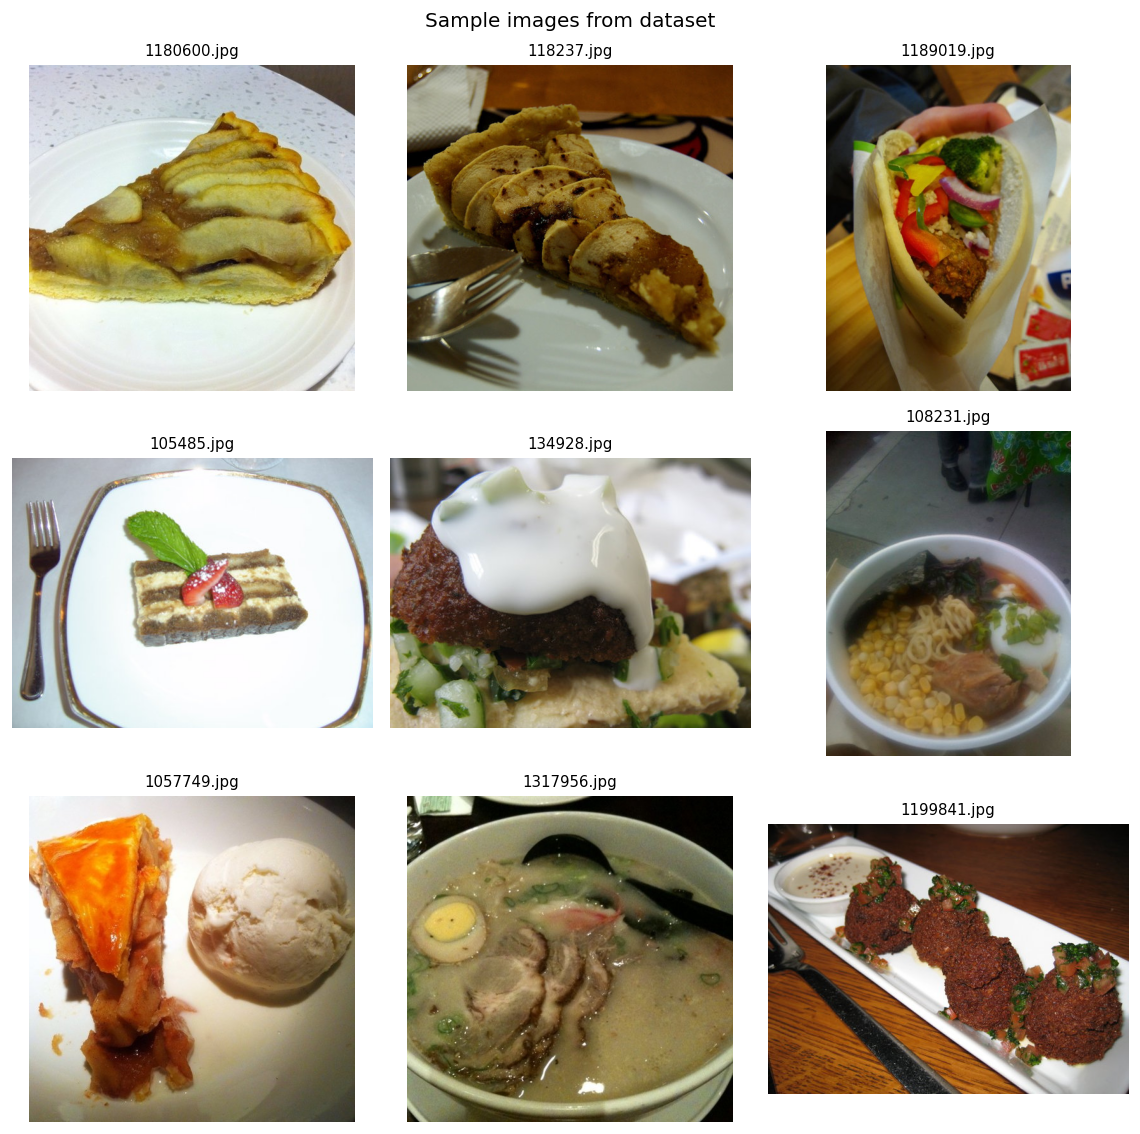


Sample image loaded for normalization:
 - path: /kaggle/input/food101tiny/data/food-101-tiny/valid/french_toast/1497156.jpg
 - shape: (384, 512, 3)
 - dtype: uint8


In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image # Import the Image class

def show_grid(paths, n=9, cols=3, title="Sample images"):
    """Show n images in a grid using matplotlib."""
    n = min(n, len(paths))
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))
    axes = np.array(axes).reshape(rows, cols) if rows*cols > 1 else np.array([[axes]])

    # Turn off all axes
    for ax in axes.ravel():
        ax.axis("off")

    # Plot images
    for ax, p in zip(axes.ravel(), paths[:n]):
        im = Image.open(p).convert("RGB")
        ax.imshow(im)
        ax.set_title(p.name, fontsize=9)
        ax.axis("off")

    plt.suptitle(title, y=0.98)
    plt.tight_layout()
    plt.show()

# Randomly sample up to 9 images for display
sample_paths = random.sample(all_images, k=min(9, len(all_images)))
show_grid(sample_paths, n=len(sample_paths), cols=3, title="Sample images from dataset")

# Load a sample image and convert to numpy array for normalization
sample_img_path = all_images[0] # Use the first image as a sample
sample_img = Image.open(sample_img_path).convert("RGB")
np_img = np.array(sample_img)
print("\nSample image loaded for normalization:")
print(" - path:", sample_img_path)
print(" - shape:", np_img.shape)
print(" - dtype:", np_img.dtype)

## 4) Normalize pixels to [0, 1]

In [ ]:
# Normalize the previously loaded sample image to [0, 1]
norm_img = np_img.astype("float32") / 255.0

print("Normalized array:")
print(" - dtype:", norm_img.dtype)
print(" - min:", float(norm_img.min()), "max:", float(norm_img.max()))


Normalized array:
 - dtype: float32
 - min: 0.0 max: 1.0


##  5) Compute the mean and std of the image’s pixels

In [ ]:
# Global mean/std across all pixels (all channels)
mean_all = float(norm_img.mean())
std_all  = float(norm_img.std())

# Per-channel mean/std (RGB). Average over H and W; keep channel dimension.
mean_ch = norm_img.mean(axis=(0, 1))
std_ch  = norm_img.std(axis=(0, 1))

print(f"Global mean: {mean_all:.4f}, Global std: {std_all:.4f}")
print("Per-channel mean (R,G,B):", np.round(mean_ch, 4))
print("Per-channel std   (R,G,B):", np.round(std_ch, 4))


Global mean: 0.4312, Global std: 0.2663
Per-channel mean (R,G,B): [0.4867 0.4425 0.3643]
Per-channel std   (R,G,B): [0.2415 0.2613 0.2801]


## (Optional) Estimate dataset-level per-channel mean/std

In [ ]:
# Compute per-channel mean/std over a subset of images (useful for normalization in DL pipelines).
def dataset_mean_std(image_paths, k=64):
    """Compute per-channel mean and std across k images."""
    import random
    sel = image_paths if len(image_paths) <= k else random.sample(image_paths, k)
    means, stds = [], []
    for p in sel:
        arr = np.array(Image.open(p).convert("RGB")).astype("float32") / 255.0
        means.append(arr.mean(axis=(0, 1)))
        stds.append(arr.std(axis=(0, 1)))
    means = np.stack(means).mean(axis=0)
    stds  = np.stack(stds).mean(axis=0)
    return means, stds

m, s = dataset_mean_std(all_images, k=min(128, len(all_images)))
print("Estimated dataset per-channel mean (R,G,B):", np.round(m, 4))
print("Estimated dataset per-channel std  (R,G,B):", np.round(s, 4))


Estimated dataset per-channel mean (R,G,B): [0.5258 0.4337 0.3318]
Estimated dataset per-channel std  (R,G,B): [0.2406 0.2462 0.2373]


## Conclusion

In this TP, we learned how to load an image dataset in Kaggle, inspect its structure, and visualize samples.  
We normalized pixel values to [0,1] and computed mean/std statistics, which are essential preprocessing steps for machine learning models.  
This practical shows the importance of **data exploration and normalization** before applying any advanced computer vision techniques.


# TP3 — Video

Tasks:
1) Load a short video clip
2) Read metadata (fps, frame count, duration)
3) Display the video inline in the notebook
4) Extract 3 frames per second and display them
5) Save the frames to a folder


In [ ]:
# If needed in a clean Kaggle runtime, uncomment:
# %pip install kagglehub opencv-python-headless

from pathlib import Path
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import cv2

from IPython.display import Video, display
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True

## 1) Download a sample video dataset with kagglehub

In [ ]:
import kagglehub
from pathlib import Path


KAGGLE_SLUG = "mistag/short-videos"

path = kagglehub.dataset_download(KAGGLE_SLUG)
DATA_ROOT = Path(path)
print("Dataset downloaded to:", DATA_ROOT)

# List top-level contents
for p in sorted(DATA_ROOT.iterdir()):
    print(("DIR " if p.is_dir() else "FILE"), "-", p.name)


Using Colab cache for faster access to the 'short-videos' dataset.
Dataset downloaded to: /kaggle/input/short-videos
DIR  - animals
DIR  - food
DIR  - insects
FILE - license.txt


## 2) Find videos (and unzip if the dataset ships as ZIP)

In [ ]:
VIDEO_EXTS = (".mp4", ".avi", ".mov", ".mkv")

# If the dataset ships as a .zip, extract it to /kaggle/working (writeable)
zip_files = list(DATA_ROOT.glob("*.zip"))
if zip_files:
    EXTRACT_DIR = Path("/kaggle/working") / (zip_files[0].stem + "_unzipped")
    EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_files[0], "r") as zf:
        zf.extractall(EXTRACT_DIR)
    SEARCH_ROOT = EXTRACT_DIR
    print("Unzipped to:", EXTRACT_DIR)
else:
    SEARCH_ROOT = DATA_ROOT

# Collect videos recursively
all_videos = [v for v in SEARCH_ROOT.rglob("*") if v.suffix.lower() in VIDEO_EXTS]
all_videos = all_videos[:20]  # limit for speed if needed
print(f"Found {len(all_videos)} video files.")
for v in all_videos[:5]:
    print(" -", v)

assert all_videos, "No videos found. Pick a different dataset slug or inspect the structure."
video_path = all_videos[0] if all_videos else None # Ensure video_path is None if no videos found
print("\nSelected video:", video_path)

Found 5 video files.
 - /kaggle/input/short-videos/animals/elefant_1280p.mp4
 - /kaggle/input/short-videos/animals/giraffes_1280p.mp4
 - /kaggle/input/short-videos/food/seafood_1280p.mp4
 - /kaggle/input/short-videos/insects/butterflies_960p.mp4
 - /kaggle/input/short-videos/insects/butterflies_1280.mp4

Selected video: /kaggle/input/short-videos/animals/elefant_1280p.mp4


## 3) Read metadata (fps, frame count, duration, resolution)

In [ ]:
cap = cv2.VideoCapture(str(video_path))
assert cap.isOpened(), f"Failed to open: {video_path}"

fps         = cap.get(cv2.CAP_PROP_FPS) or 0.0
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0.0
width       = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height      = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
duration_s  = (frame_count / fps) if fps > 0 else 0.0

print(f"FPS:       {fps:.3f}")
print(f"Frames:    {int(frame_count)}")
print(f"Duration:  {duration_s:.3f} s")
print(f"Resolution:{width}x{height}")

cap.release()


FPS:       29.970
Frames:    1064
Duration:  35.502 s
Resolution:1280x720


## 4) Display the video inline

In [ ]:
from IPython.display import Video, display
import os

# Example: pick the first .mp4 file inside your dataset
video_files = list(DATA_ROOT.rglob("*.mp4"))
video_path = video_files[0] if video_files else None

# Display the video if found
if video_path and os.path.exists(video_path):
    display(Video(filename=str(video_path),
                  embed=True,
                  html_attributes="controls muted loop style='max-width: 720px;'"))
else:
    print("No video file found to display.")


TypeError: stat: path should be string, bytes, os.PathLike or integer, not NoneType

## 5) Extract 3 frames per second and show them

In [ ]:
import math

def extract_frames_at_rate(video_file, rate_fps=3.0, max_frames=None):
    """Extract frames at a given sampling rate (frames/second) using timestamp seeking."""
    cap = cv2.VideoCapture(str(video_file))
    assert cap.isOpened(), f"Cannot open {video_file}"

    fps   = cap.get(cv2.CAP_PROP_FPS) or 0.0
    nfrm  = cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0.0
    dur_s = (nfrm / fps) if fps > 0 else 0.0

    step_s = 1.0 / float(rate_fps)
    t = 0.0
    frames = []

    while t <= dur_s + 1e-6:
        cap.set(cv2.CAP_PROP_POS_MSEC, t * 1000.0)    # seek by time
        ok, frame_bgr = cap.read()
        if not ok:
            break
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        frames.append((t, frame_rgb))
        if max_frames and len(frames) >= max_frames:
            break
        t += step_s

    cap.release()
    return frames, fps, dur_s

frames_3fps, true_fps, dur_s = extract_frames_at_rate(video_path, rate_fps=3.0)
print(f"Extracted {len(frames_3fps)} frames at ~3 fps over {dur_s:.2f}s (source fps={true_fps:.3f}).")


### Visualize extracted frames (grid)

In [ ]:
import matplotlib.pyplot as plt

def show_frames_grid(frames, n=9, cols=3, title="Extracted frames (3 fps)"):
    n = min(n, len(frames))
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3.5*cols, 3.5*rows))
    axes = np.array(axes).reshape(rows, cols) if rows*cols > 1 else np.array([[axes]])

    for ax in axes.ravel():
        ax.axis("off")

    for ax, (t, rgb) in zip(axes.ravel(), frames[:n]):
        ax.imshow(rgb)
        ax.set_title(f"t={t:.2f}s", fontsize=10)
        ax.axis("off")

    plt.suptitle(title, y=0.98)
    plt.tight_layout()
    plt.show()

show_frames_grid(frames_3fps, n=min(9, len(frames_3fps)), cols=3)


## 6) Save frames under /kaggle/working

In [ ]:
from PIL import Image

OUT_DIR = Path("/kaggle/working/frames_3fps")
OUT_DIR.mkdir(parents=True, exist_ok=True)

count = 0
for t, rgb in frames_3fps:
    ms = int(round(t * 1000))  # timestamp in ms for filename
    out_path = OUT_DIR / f"{video_path.stem}_t{ms:06d}.jpg"
    Image.fromarray(rgb).save(out_path, quality=90)
    count += 1

print(f"Saved {count} frames to: {OUT_DIR}")


## Conclusion

In this TP, we loaded a sample video, inspected its metadata, and visualized it directly inside the notebook.  
We extracted frames at 3 fps, displayed them, and saved them for later processing.  
This workflow shows the essential preprocessing steps for video analysis in data engineering and machine learning.


# TP4 — Audio

Tasks:
1) Load a .wav or .ogg file with librosa
2) Display signal size and duration
3) Plot the waveform
4) Compute and display a spectrogram
5) Play the audio in Jupyter


## 1) Locate audio dataset

In [ ]:
# If missing in your environment, uncomment:
# %pip install librosa soundfile

import kagglehub
path = kagglehub.dataset_download("ouaraskhelilrafik/tp-02-audio")  # example
DATA_ROOT = Path(path)

# Collect all audio files (assuming they are directly in DATA_ROOT or subdirectories)
AUDIO_EXTS = (".wav", ".ogg", ".mp3", ".flac") # Add other common audio extensions if needed

def collect_audio_files(root: Path):
    """Collects all audio files with specified extensions from a root directory."""
    audio_files = [p for p in root.rglob("*") if p.suffix.lower() in AUDIO_EXTS]
    return audio_files

all_audio = collect_audio_files(DATA_ROOT)
print(f"Found {len(all_audio)} audio files.")
for p in all_audio[:5]: # Print first 5 for preview
    print(" -", p)

assert len(all_audio) > 0, "No audio files found. Check dataset structure or file extensions."

Using Colab cache for faster access to the 'tp-02-audio' dataset.
Found 600 audio files.
 - /kaggle/input/tp-02-audio/Data/Data/102 - Rooster/5-194930-A.ogg
 - /kaggle/input/tp-02-audio/Data/Data/102 - Rooster/2-95258-B.ogg
 - /kaggle/input/tp-02-audio/Data/Data/102 - Rooster/2-81270-A.ogg
 - /kaggle/input/tp-02-audio/Data/Data/102 - Rooster/3-154957-A.ogg
 - /kaggle/input/tp-02-audio/Data/Data/102 - Rooster/2-65750-A.ogg


In [ ]:
print(path)

/kaggle/input/tp-02-audio


## 2) Load one audio file with librosa.load

In [ ]:
# Pick one representative audio file
audio_path = all_audio[0]
print("Selected file:", audio_path)

# Load audio with original sampling rate (sr=None) and keep stereo if present (mono=False)
y, sr = librosa.load(audio_path, sr=None, mono=False)

# Determine shape: mono -> (n_samples,), stereo/multichannel -> (n_channels, n_samples)
if y.ndim == 1:
    n_channels = 1
    n_samples = y.shape[0]
else:
    n_channels = y.shape[0]
    n_samples = y.shape[1]

duration_sec = n_samples / float(sr)

print(f"Sampling rate (Hz): {sr}")
print(f"Channels: {n_channels}")
print(f"Total samples: {n_samples}")
print(f"Duration (sec): {duration_sec:.3f}")
print(f"Dtype: {y.dtype}, min={y.min():.3f}, max={y.max():.3f}")


Selected file: /kaggle/input/tp-02-audio/Data/Data/102 - Rooster/5-194930-A.ogg
Sampling rate (Hz): 44100
Channels: 1
Total samples: 220544
Duration (sec): 5.001
Dtype: float32, min=-0.981, max=0.918


## 3) Plot waveform

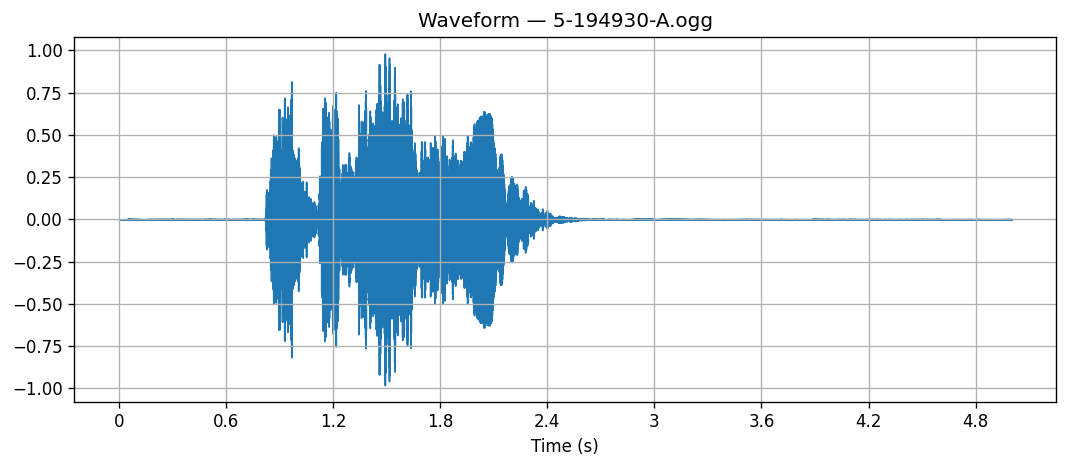

In [ ]:
# For plotting, if stereo, show each channel; if mono, show single trace.
def plot_waveform(y, sr, title="Waveform"):
    plt.figure()
    if y.ndim == 1:
        librosa.display.waveshow(y, sr=sr)
    else:
        # Plot first two channels (if more than 2, adapt as needed)
        ch_to_plot = min(2, y.shape[0])
        offset = 0.8  # vertical offset between channels for readability
        for ch in range(ch_to_plot):
            librosa.display.waveshow(y[ch], sr=sr, alpha=0.8, label=f"ch{ch+1}", offset=(ch*offset))
        plt.legend()
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

plot_waveform(y, sr, title=f"Waveform — {audio_path.name}")


## 4) Compute & display a spectrogram

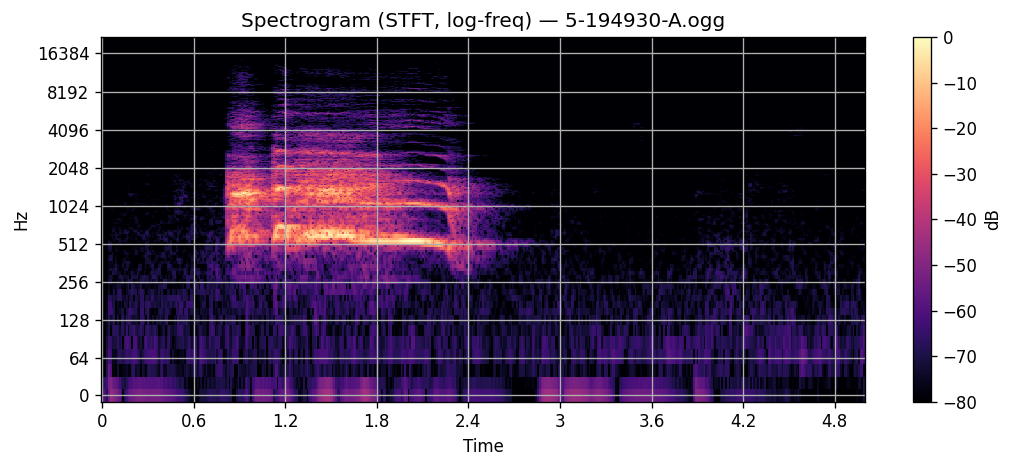

In [ ]:
# Use mono for spectrogram visualization to keep things simple
y_mono = librosa.to_mono(y) if y.ndim > 1 else y

# Short-Time Fourier Transform (STFT) parameters
n_fft = 2048      # window size (samples)
hop_length = 512  # step between windows (samples)

# Compute magnitude spectrogram
S = np.abs(librosa.stft(y_mono, n_fft=n_fft, hop_length=hop_length))
S_db = librosa.amplitude_to_db(S, ref=np.max)  # convert to dB scale (log)

plt.figure(figsize=(9, 4))
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length,
                         x_axis="time", y_axis="log")  # log-frequency axis
plt.colorbar(label="dB")
plt.title(f"Spectrogram (STFT, log-freq) — {audio_path.name}")
plt.tight_layout()
plt.show()

# (Optional) Mel-spectrogram
# mel = librosa.feature.melspectrogram(y=y_mono, sr=sr, n_mels=64, fmax=sr/2)
# mel_db = librosa.power_to_db(mel, ref=np.max)
# plt.figure(figsize=(9, 4))
# librosa.display.specshow(mel_db, sr=sr, x_axis="time", y_axis="mel")
# plt.colorbar(label="dB")
# plt.title(f"Mel-Spectrogram — {audio_path.name}")
# plt.tight_layout()
# plt.show()


## 5) Play audio inline (Jupyter)

In [ ]:
# Easiest: pass the filename (lets the browser stream it)
display(Audio(filename=str(audio_path)))

# Alternative: pass raw numpy data (useful if you trimmed or processed the signal)
# display(Audio(data=y_mono, rate=sr))


## (Optional) Save figures or trimmed audio to /kaggle/working

In [ ]:
# /kaggle/input is read-only; save outputs under /kaggle/working
OUT_DIR = Path("/kaggle/working/audio_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Example: save a 5-second trim (if file is longer)
t_end = min(5.0, duration_sec)
y_trim = y_mono[: int(t_end * sr)]
from scipy.io import wavfile
wavfile.write(OUT_DIR / f"{audio_path.stem}_trim5s.wav", sr, (y_trim * 32767).astype(np.int16))
print("Saved:", OUT_DIR / f"{audio_path.stem}_trim5s.wav")


Saved: /kaggle/working/audio_out/5-194930-A_trim5s.wav


# TP5 — Time Series (AirPassengers)

Tasks:
1) Import the dataset AirPassengers
2) Show the first 5 rows
3) Convert the date column to datetime index
4) Visualize the series
5) Compute and plot a 12-month moving average
6) Decompose the series (trend + seasonality + residuals)


In [ ]:
# If needed (uncomment to install in Kaggle runtime)
# %pip install pandas matplotlib statsmodels kagglehub

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import kagglehub
from pathlib import Path

plt.rcParams["figure.figsize"] = (9, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 120


## 1) Download dataset with kagglehub

In [ ]:
# Download dataset from Kaggle with kagglehub
path = kagglehub.dataset_download("erogluegemen/airline-passengers")
DATA_ROOT = Path(path)
print("Dataset downloaded to:", DATA_ROOT)

# List files in dataset folder
for p in sorted(DATA_ROOT.iterdir()):
    print(" -", p.name)


100%|██████████| 807/807 [00:00<00:00, 1.55MB/s]

Extracting files...
Dataset downloaded to: /root/.cache/kagglehub/datasets/erogluegemen/airline-passengers/versions/1
 - airline-passengers.csv


## 2) Load CSV into pandas DataFrame

In [ ]:
# From Kaggle page we know the file is "AirPassengers.csv"
csv_path = DATA_ROOT / "airline-passengers.csv"

df = pd.read_csv(csv_path)
print("Raw data:")
print(df.head())
print("\nDataFrame info:")
print(df.info())

Raw data:
     month  total_passengers
0  1949-01               112
1  1949-02               118
2  1949-03               132
3  1949-04               129
4  1949-05               121

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   month             144 non-null    object
 1   total_passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None


## 3) Convert date column to datetime index

In [ ]:
# Usually dataset has columns like 'Month' and 'Passengers'
# Let's rename to lowercase for convenience
df = df.rename(columns={"month": "date", "total_passengers": "passengers"})

# Convert to datetime and set as index
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date").sort_index()
df = df.asfreq("MS")  # monthly start frequency
df["passengers"] = df["passengers"].astype("float64")

print(df.head())
print("\nIndex info:", df.index.freq)

            passengers
date                  
1949-01-01       112.0
1949-02-01       118.0
1949-03-01       132.0
1949-04-01       129.0
1949-05-01       121.0

Index info: <MonthBegin>


## 4) Visualize the time series

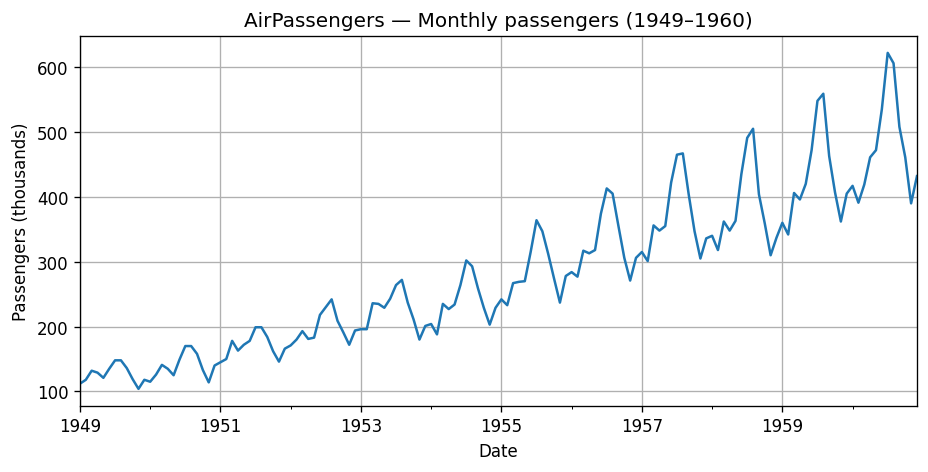

In [ ]:
ax = df["passengers"].plot(title="AirPassengers — Monthly passengers (1949–1960)")
ax.set_xlabel("Date")
ax.set_ylabel("Passengers (thousands)")
plt.show()


## 5) Compute & plot 12-month moving average

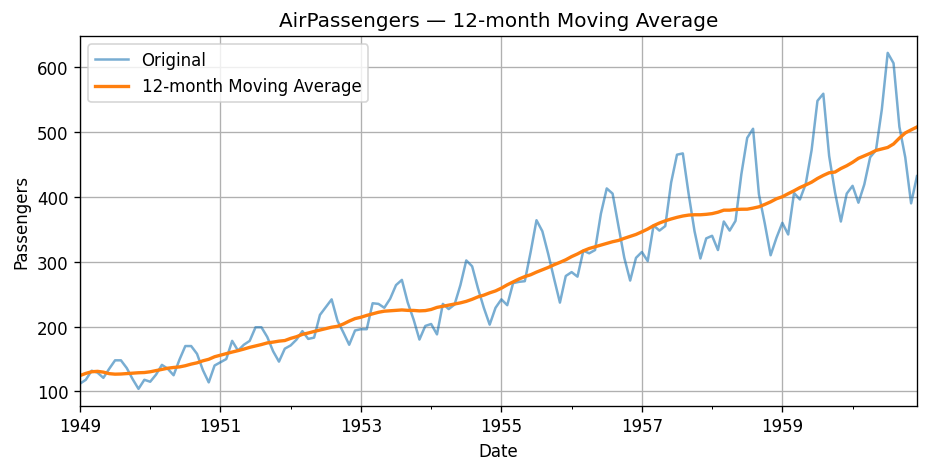

In [ ]:
ma12 = df["passengers"].rolling(window=12, center=True, min_periods=6).mean()

ax = df["passengers"].plot(label="Original", alpha=0.6)
ma12.plot(ax=ax, label="12-month Moving Average", linewidth=2)
ax.set_title("AirPassengers — 12-month Moving Average")
ax.set_xlabel("Date")
ax.set_ylabel("Passengers")
ax.legend()
plt.show()


## 6) Seasonal decomposition (trend, seasonality, residuals)

In [ ]:
# Additive model
result_add = seasonal_decompose(df["passengers"], model="additive", period=12)
fig = result_add.plot()
fig.suptitle("Seasonal Decomposition (Additive)", y=1.02)
plt.show()

# Optional: multiplicative decomposition
# result_mul = seasonal_decompose(df["passengers"], model="multiplicative", period=12)
# result_mul.plot()
# plt.show()


We successfully:
- Loaded the AirPassengers dataset via kagglehub
- Parsed the date column and set it as a proper time index
- Visualized the series and observed growth + yearly seasonality
- Computed a 12-month moving average to smooth short-term variation
- Decomposed the series into trend, seasonality, and residuals using statsmodels


# TP6 — Graphs

Tasks:
1) Load a Pajek `.net` graph with NetworkX
2) Show number of nodes & edges
3) Visualize the graph with matplotlib
4) Compute node degrees
5) Plot the degree distribution (histogram)
6) Visualize interactively with ipycytoscape


## Setup (install + imports)

In [ ]:
%pip install ipycytoscape

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.6 MB/s eta 0:00:00


In [ ]:
# If these packages are not already available in your Kaggle environment, uncomment:
# %pip install kagglehub networkx ipycytoscape

import os
from pathlib import Path
import zipfile

import networkx as nx
import matplotlib.pyplot as plt

# For interactive widget
from IPython.display import display
from ipycytoscape import CytoscapeWidget

# Plot style
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True


## 1) Download the dataset with kagglehub

In [ ]:
import kagglehub

# Download the dataset to a local, read-only cache folder (returned path)
path = kagglehub.dataset_download("mateuscco/toy-network-datasets")
DATA_ROOT = Path(path)
print("Dataset downloaded to:", DATA_ROOT)

# List directory contents for inspection
for p in sorted(DATA_ROOT.iterdir()):
    kind = "DIR " if p.is_dir() else "FILE"
    print(kind, "-", p.name)


100%|██████████| 68.7k/68.7k [00:00<00:00, 18.2MB/s]

Extracting files...
Dataset downloaded to: /root/.cache/kagglehub/datasets/mateuscco/toy-network-datasets/versions/1
FILE - 26KeroNetwork.net
FILE - NetScience.net
FILE - Ring25.net
FILE - YeastS.net
FILE - imports_manufactures.net


## 2) Find a Pajek .net file (and unzip if necessary)

In [ ]:
NET_EXT = ".net"

# If the dataset ships as a .zip, extract it to /kaggle/working (writeable)
zip_files = list(DATA_ROOT.glob("*.zip"))
if zip_files:
    EXTRACT_DIR = Path("/kaggle/working") / "toy_networks_unzipped"
    EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_files[0], "r") as zf:
        zf.extractall(EXTRACT_DIR)
    print("Unzipped to:", EXTRACT_DIR)
    SEARCH_ROOT = EXTRACT_DIR
else:
    SEARCH_ROOT = DATA_ROOT

# Collect Pajek .net files recursively
net_files = sorted(SEARCH_ROOT.rglob(f"*{NET_EXT}"))
print(f"Found {len(net_files)} .net files.")
for f in net_files[:5]:
    print(" -", f)

assert len(net_files) > 0, "No .net files found. Check dataset structure."
net_path = net_files[0]
print("\nSelected Pajek file:", net_path)


Found 5 .net files.
 - /root/.cache/kagglehub/datasets/mateuscco/toy-network-datasets/versions/1/26KeroNetwork.net
 - /root/.cache/kagglehub/datasets/mateuscco/toy-network-datasets/versions/1/NetScience.net
 - /root/.cache/kagglehub/datasets/mateuscco/toy-network-datasets/versions/1/Ring25.net
 - /root/.cache/kagglehub/datasets/mateuscco/toy-network-datasets/versions/1/YeastS.net
 - /root/.cache/kagglehub/datasets/mateuscco/toy-network-datasets/versions/1/imports_manufactures.net

Selected Pajek file: /root/.cache/kagglehub/datasets/mateuscco/toy-network-datasets/versions/1/26KeroNetwork.net


## 3) Load with NetworkX & report size

In [ ]:
# Read Pajek file → may return Multi(Di)Graph
G0 = nx.read_pajek(str(net_path))

# Convert to a simple undirected Graph (merge parallel edges)
# Adapt if you specifically need direction/multiedges.
G = nx.Graph(G0)

n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()

print(f"Nodes: {n_nodes}")
print(f"Edges: {n_edges}")


Nodes: 135
Edges: 318


## 4) Visualize with matplotlib

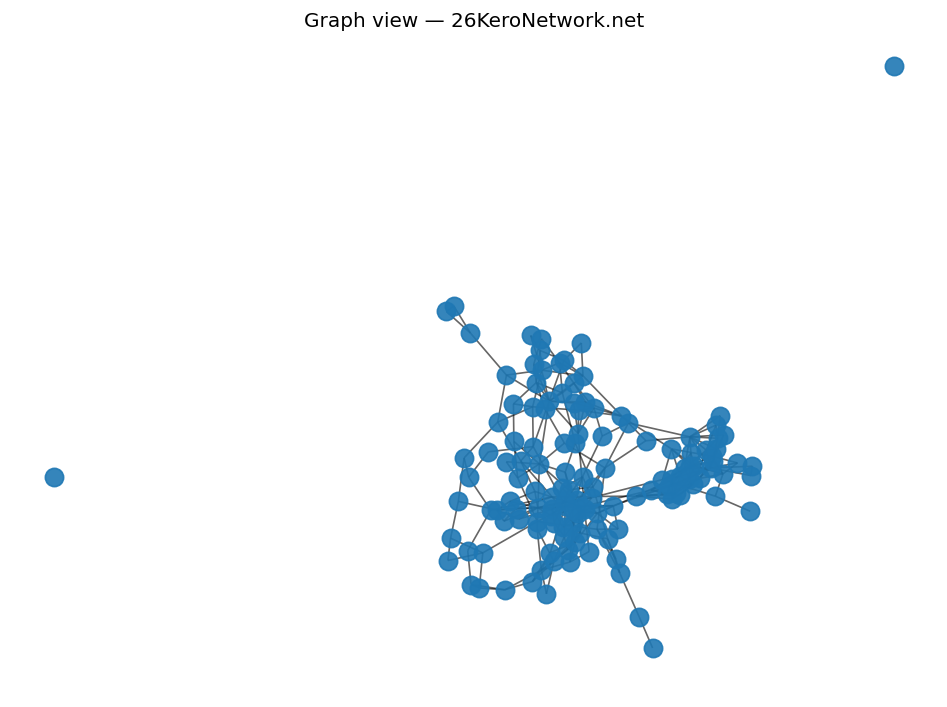

In [ ]:
# Spring layout is a solid default for small graphs; fix seed for reproducibility
pos = nx.spring_layout(G, seed=42)

plt.figure()
nx.draw_networkx_nodes(G, pos, node_size=120, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.6)
# Optional labels (can clutter): nx.draw_networkx_labels(G, pos, font_size=7)
plt.title(f"Graph view — {net_path.name}")
plt.axis("off")
plt.tight_layout()
plt.show()


## 5) Degree computation & histogram

Degree preview (first 10): [('1', 3), ('2', 2), ('3', 2), ('4', 4), ('5', 4), ('6', 2), ('7', 3), ('8', 3), ('9', 4), ('10', 7)]
Min=0, Max=12, Avg=4.71


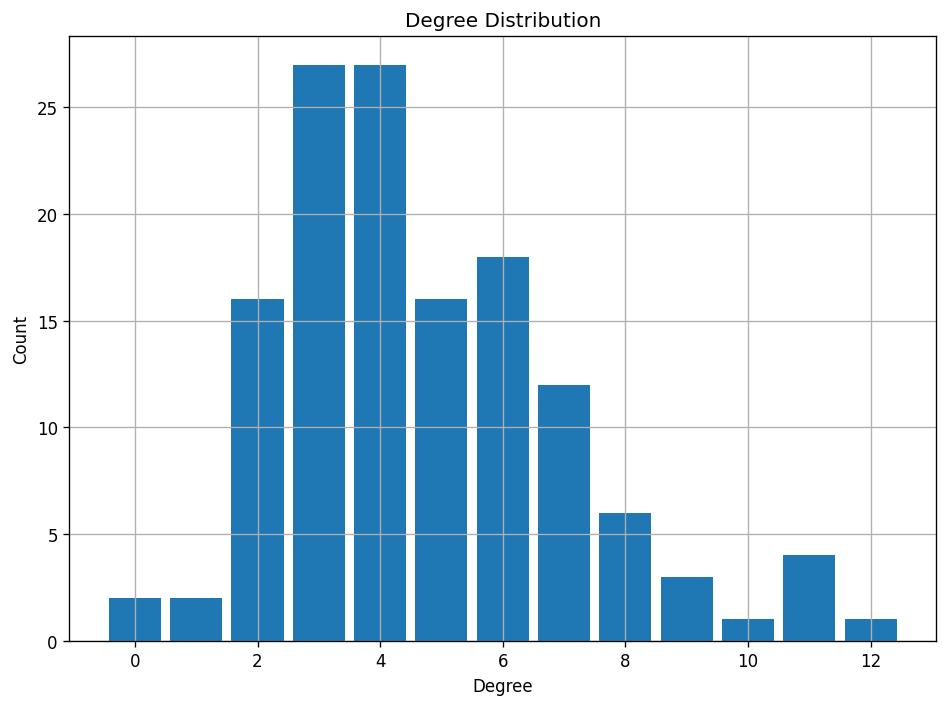

In [ ]:
# Degree per node
deg_dict = dict(G.degree())
degrees = list(deg_dict.values())

print("Degree preview (first 10):", list(deg_dict.items())[:10])
print(f"Min={min(degrees)}, Max={max(degrees)}, Avg={sum(degrees)/len(degrees):.2f}")

# Histogram of degrees
plt.figure()
plt.hist(degrees, bins=range(0, max(degrees)+2), align="left", rwidth=0.85)
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree Distribution")
plt.tight_layout()
plt.show()


## 6) Interactive visualization with ipycytoscape

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
cy = CytoscapeWidget()
cy.set_style([
    {
        "selector": "node",
        "style": {
            "label": "data(label)",
            "width": "18px",
            "height": "18px",
            "background-color": "#4C78A8"
        }
    },
    {
        "selector": "edge",
        "style": {
            "width": 1.0,
            "line-color": "#9ecae1",
            "curve-style": "bezier"
        }
    }
])

# Add the NetworkX graph directly
cy.graph.add_graph_from_networkx(G)

# Choose a layout ('cose', 'concentric', 'circle', 'breadthfirst', ...)
cy.set_layout(name="cose")
display(cy)

CytoscapeWidget(cytoscape_layout={'name': 'cose'}, cytoscape_style=[{'selector': 'node', 'style': {'label': 'd…

# Conclusion

In this TP, we successfully loaded and explored a graph dataset in Pajek format.  
We inspected its size (nodes and edges), visualized the structure with matplotlib, computed degree statistics, and examined the degree distribution.  
Finally, we used ipycytoscape for an interactive visualization.  
This shows the importance of graph analysis tools for understanding network structure and connectivity.
